In [1]:
import sys
import pickle
import numpy as np

sys.path.append('../')

import helper
from FeatEngg import ngramEnc,ctdEnc,gaacEnc
from mySVM.model import SVMRegressor


In [2]:
class Model:
    def __init__(self,enzs,X,y,tr_idx,te_idx,pca_components=40,regCparam=1,
                 kernparam='linear',random_seed=None,optimizeQ=False,verboseQ=False):
    
        self.ytrain,self.ytest = y[tr_idx],y[te_idx]
        self.pca_components=pca_components
        self.optimizeQ=optimizeQ
        self.verboseQ=verboseQ
        self.rs=random_seed        
        self.regCparam=regCparam
        self.kernparam=kernparam

            
    def get_SVM(self):
        return SVMRegressor(self.Xtrain,self.Xtest,self.ytrain,self.ytest,
                            pca_comp=self.pca_components,regC=self.regCparam,
                            kern=self.kernparam,optimize=self.optimizeQ,
                            verbose=self.verboseQ,random_seed=self.rs)

    
class GAARegressor(Model):
    
    def __init__(self,enzs,X,y,tr_idx,te_idx,k=7,s=1,pca_components=40,regCparam=20,kernparam='rbf',
                 inc_count=False,optimizeQ=False,verboseQ=False,random_seed=None):

        self.gc = gaacEnc.GAAC()
        X_gaac = self.gc.transform(X)
        self.Xtrain_raw,self.ytrain,self.Xtest_raw,self.ytest = X_gaac[tr_idx],y[tr_idx],X_gaac[te_idx],y[te_idx]
        self.ng = ngramEnc.Ngram(self.Xtrain_raw,k,s,inc_count)
        self.ng.fit()
        self.Xtrain,self.Xtest = self.ng.transform(self.Xtrain_raw),self.ng.transform(self.Xtest_raw)

        super().__init__(enzs,X,y,tr_idx,te_idx,pca_components,regCparam,
                 kernparam,random_seed,optimizeQ,verboseQ)
        
        self.SVMobject = self.get_SVM()
        self.model = self.SVMobject.model


In [3]:
enz_datafile = '../Data/AlignedRegressionData.txt'

X,y,enz_name = helper.parseEnzymeFileRegression(enz_datafile)

In [30]:
np.random.seed(8268)

In [31]:
teidx,tridx = helper.modified_split(enz_name)

In [32]:
print(teidx)

[ 68  39  96  48  10  56 108  44 100 109 107  31  82  97  85  14  76  33
  25 110  53  29  67  13   2  91]


In [33]:
X = np.array(list(map(list,X)))

In [34]:
grmodel = GAARegressor(enz_name,X[:,140:505],y,tridx,teidx,inc_count=False)

In [35]:
grmodel.SVMobject.error_test

0.10675508882773727

In [36]:
grmodel.SVMobject.ypredtest

array([0.12091589, 0.41867087, 0.46829393, 0.83467546, 0.20395744,
       0.61716056, 0.07288726, 0.52054993, 0.60702109, 0.2211218 ,
       0.21569261, 0.5687296 , 0.17071486, 0.49493692, 0.03951793,
       0.09309442, 0.15742233, 0.22064054, 0.02288095, 0.22157226,
       0.40475015, 0.23758283, 0.19932632, 0.54749641, 0.14245489,
       0.42088745])

In [38]:
for i,j,k,l in zip(teidx,enz_name[teidx],y[teidx],grmodel.SVMobject.ypredtest):
    print(i,j,k,l)

68 Cuphea_viscosisssima_(CvB2MT7 0.06699999999999999 0.12091588614777621
39 Cuphea_viscosisssima_(CvB2MT22 0.6 0.4186708657029997
96 rTE40 0.308 0.46829392968442396
48 Cuphea_viscosisssima_(CvB2MT30 0.7989999999999999 0.8346754648069237
10 Cocos_nucifera_(CnFatB3) 0.52 0.2039574410819976
56 Cuphea_viscosisssima_(CvB2MT38 0.5080000000000001 0.6171605615926092
108 Ulmus_americana 0.81 0.07288725986984992
44 Cuphea_viscosisssima_(CvB2MT27 0.6829999999999999 0.5205499303666483
100 rTE52 0.6809999999999999 0.6070210912594323
109 Umbellularia_californica_(UcFatB1) 0.8271455115292411 0.22112180030028505
107 UcFatB1(T231K) 0.8271455115292411 0.21569261465919348
31 Cuphea_viscosisssima_(CvB2MT15 0.602 0.5687296023036945
82 Micromonas_pusilla 0.04 0.17071486473022562
97 rTE44 0.109 0.49493692132227973
85 Ricinus_communis 0.001 0.039517933217163126
14 Cuphea_decandra_(Cd1FatB1) 0.007917656373713382 0.09309441505557811
76 Helianthus_Annuus_(HaFatA1) 0.0 0.1574223273489465
33 Cuphea_viscosisssima_(

In [23]:
def multiprocess_func(randomseed):
    np.random.seed(randomseed)
    test_idx_i,train_idx_i = helper.modified_split(enz_name)
    grmodel = GAARegressor(enz_name,X[:,140:505],y,train_idx_i,test_idx_i,inc_count=False)
    return grmodel.SVMobject.error_test
    
    


In [24]:
import multiprocessing as mp
print(mp.cpu_count())
pool = mp.Pool(mp.cpu_count())

20


In [25]:
%%time
mses = list(pool.map(multiprocess_func,[i for i in range(10000)]))

CPU times: user 85 ms, sys: 16 ms, total: 101 ms
Wall time: 1min 5s


In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

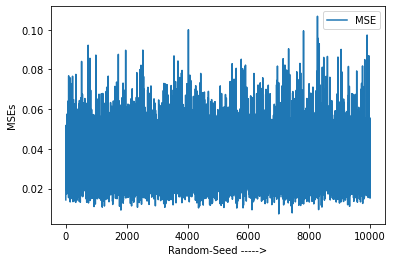

In [27]:
plt.plot(range(len(mses)),mses)
plt.xlabel('Random-Seed ----->')
plt.ylabel('MSEs')
plt.legend(['MSE'])


In [28]:
np.mean(mses),np.std(mses),min(mses),max(mses)

(0.034801507218840344,
 0.012725203052354023,
 0.007250534277650756,
 0.10675508750139845)

In [29]:
np.argmax(mses)

8268